In [1]:
!pip install --upgrade --no-cache-dir gdown

  Attempting uninstall: gdown
    Found existing installation: gdown 4.7.3
    Uninstalling gdown-4.7.3:
      Successfully uninstalled gdown-4.7.3


In [2]:
#https://drive.google.com/file/d/1uTLwj2Jvflvpg-omVVcpHhF2uEhv3m9W/view?usp=sharing
!gdown 1uTLwj2Jvflvpg-omVVcpHhF2uEhv3m9W

Downloading...
From (original): https://drive.google.com/uc?id=1uTLwj2Jvflvpg-omVVcpHhF2uEhv3m9W
From (redirected): https://drive.usercontent.google.com/download?id=1uTLwj2Jvflvpg-omVVcpHhF2uEhv3m9W&confirm=t&uuid=32d806c0-376a-4b98-8c32-bd0ec39e840f
To: /content/fruit.zip
100% 30.6M/30.6M [00:00<00:00, 39.3MB/s]


In [3]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.transforms import v2
import torch.optim as optim

In [4]:
!unzip fruit.zip

Archive:  fruit.zip
   creating: MY_data/
   creating: MY_data/predict/
  inflating: MY_data/predict/0.jpeg  
  inflating: MY_data/predict/00.jpeg  
  inflating: MY_data/predict/011.jpeg  
  inflating: MY_data/predict/012.jpeg  
  inflating: MY_data/predict/0122.jpeg  
  inflating: MY_data/predict/0124.jpeg  
  inflating: MY_data/predict/023.jpeg  
  inflating: MY_data/predict/1.jpeg  
  inflating: MY_data/predict/147.jpeg  
  inflating: MY_data/predict/2.jpeg  
  inflating: MY_data/predict/202.jpeg  
  inflating: MY_data/predict/22.jpeg  
  inflating: MY_data/predict/3.jpeg  
  inflating: MY_data/predict/321.jpeg  
  inflating: MY_data/predict/33.jpeg  
  inflating: MY_data/predict/365.jpeg  
  inflating: MY_data/predict/4.jpeg  
  inflating: MY_data/predict/41.jpeg  
  inflating: MY_data/predict/65.jpeg  
  inflating: MY_data/predict/659.jpeg  
  inflating: MY_data/predict/66.jpeg  
  inflating: MY_data/predict/68.jpeg  
  inflating: MY_data/predict/77.jpeg  
  inflating: MY_data/pre

# Reading some images

In [6]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import random

root_train_dir = '/content/MY_data/train'


classes = {
    label_idx: class_name for label_idx, class_name in enumerate(sorted(os.listdir(root_train_dir)))
}


In [7]:
classes

{0: 'apple',
 1: 'avocado',
 2: 'banana',
 3: 'cherry',
 4: 'kiwi',
 5: 'mango',
 6: 'orange',
 7: 'pinenapple',
 8: 'strawberries',
 9: 'watermelon'}

In [8]:
img_paths = []
labels = []

for label_idx, class_name in (classes.items()):
    class_dir = os.path.join(root_train_dir, class_name)
    for img_filename in (os.listdir(class_dir)):
        img_path = os.path.join(class_dir ,img_filename)
        img_paths.append(img_path)
        labels.append(label_idx)

In [9]:
for label in (os.listdir('/content/MY_data/train')):
    num = len(os.listdir(os.path.join('/content/MY_data/train', label)))
    print(f'Number of {label} : {num}')

Number of cherry : 230
Number of watermelon : 230
Number of banana : 230
Number of pinenapple : 230
Number of mango : 231
Number of kiwi : 230
Number of avocado : 230
Number of strawberries : 230
Number of apple : 230
Number of orange : 230


In [10]:
def process_image(root_dir, classes):
    X = []  # image_paths
    y = []  # label
    for label_idx, class_name in (classes.items()):
        class_dir = os.path.join(root_dir, class_name)
        for img_filename in (os.listdir(class_dir)):
            img_path = os.path.join(class_dir, img_filename)
            X.append(img_path)
            y.append(label_idx)
    return X, y

In [11]:
train_root_dir = '/content/MY_data/train'
val_root_dir = '/content/MY_data/test'
X_train, y_train = process_image(train_root_dir, classes)
X_val, y_val = process_image(val_root_dir, classes)


In [12]:
import os
import random
from PIL import Image
import numpy as np

def show_random_images(X_train, y_train, rows=5, cols=5):
    # Select random images and labels
    indices = random.sample(range(len(X_train)), rows * cols)

    # Create figure and axes
    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

    # Loop through the indices and plot images
    for i, ax in enumerate(axes.flat):
        index = indices[i]
        image_path = X_train[index]
        label = y_train[index]

        # Open and resize the image

        with Image.open(image_path) as img:
            img = img.resize((100, 100))  # Adjust size as needed

        # Plot the image
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f'Label: {classes[label]}')
        print

    # Adjust layout
    plt.tight_layout()
    plt.show()


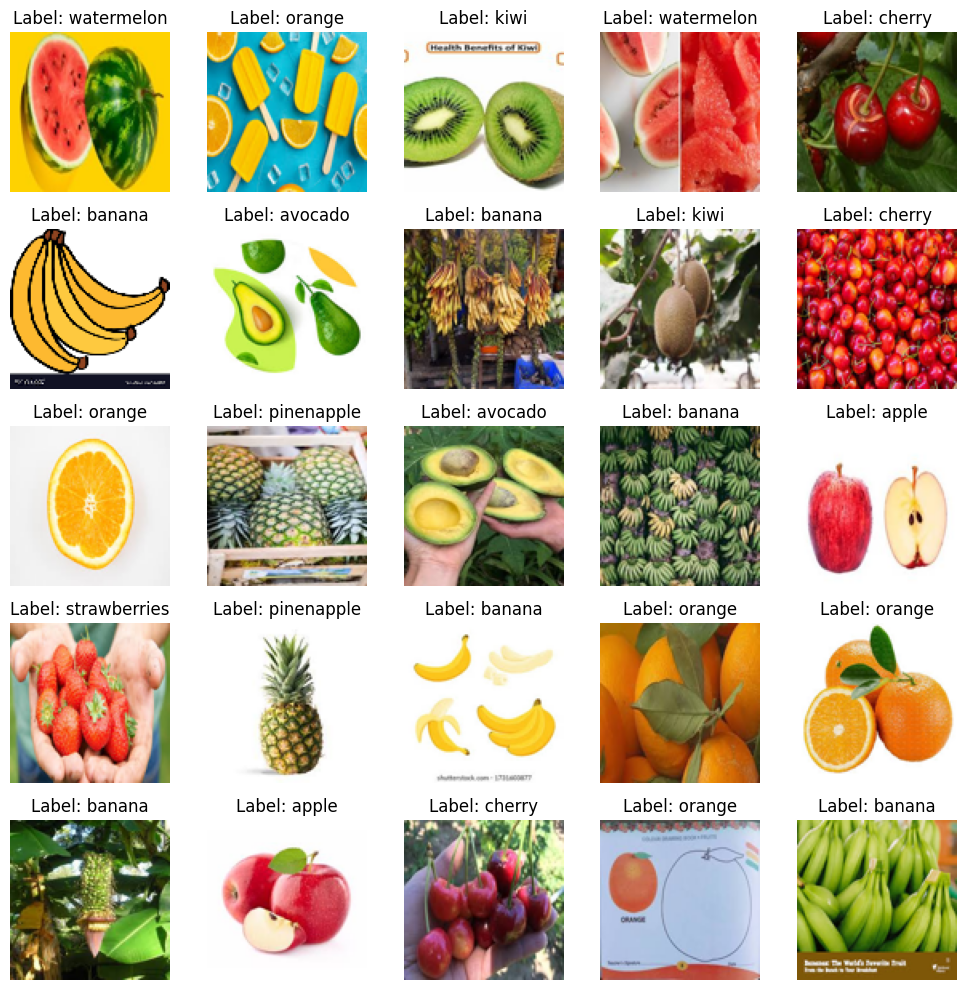

In [13]:
show_random_images(X_train, y_train)

# Dataset class

In [14]:
from torchvision.transforms import AutoAugment

def transform_train(img, img_size=(224, 224)):
    img = img.resize(img_size)
    img = np.array(img)[..., :3]
    img = torch.tensor(img).permute(2, 0, 1).float()
    #auto_aug = AutoAugment()
    #img = auto_aug(img)
    normalized_img = img / 255.0
    return normalized_img

def transform_val_n_test(img, img_size=(224, 224)):
  img = img.resize(img_size)
  img = np.array(img)[..., :3]
  img = torch.tensor(img).permute(2, 0, 1).float()
  normalized_img = img / 255.0
  #auto_aug = AutoAugment()
  #normalized_img = auto_aug(normalized_img)

  return normalized_img

In [15]:
from torch.utils.data import Dataset, DataLoader

class FruitDataset(Dataset):
    def __init__(self, X, y, transform=None):
        super().__init__()
        self.transform = transform
        self.img_paths = X
        self.labels = y

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        img_path = self.img_paths[index]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, self.labels[index]

In [29]:
train_dataset = FruitDataset(X_train, y_train, transform=transform_train)
val_dataset = FruitDataset(X_val, y_val, transform=transform_val_n_test)


In [30]:

train_batch_size = 32


train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=train_batch_size)



In [31]:
next(iter(train_loader))

[tensor([[[[0.5843, 0.7333, 0.8588,  ..., 0.2549, 0.2431, 0.2314],
           [0.5882, 0.7294, 0.8549,  ..., 0.2510, 0.2314, 0.2118],
           [0.5882, 0.7255, 0.8471,  ..., 0.2510, 0.2235, 0.1961],
           ...,
           [0.0588, 0.0588, 0.0588,  ..., 0.0039, 0.0000, 0.0039],
           [0.0588, 0.0588, 0.0588,  ..., 0.0000, 0.0039, 0.0118],
           [0.0627, 0.0627, 0.0627,  ..., 0.0000, 0.0078, 0.0157]],
 
          [[0.7020, 0.8118, 0.8941,  ..., 0.5020, 0.5137, 0.5216],
           [0.7020, 0.8157, 0.8902,  ..., 0.5020, 0.5059, 0.5098],
           [0.7059, 0.8196, 0.8902,  ..., 0.4902, 0.4902, 0.4863],
           ...,
           [0.2118, 0.2118, 0.2118,  ..., 0.0510, 0.0392, 0.0353],
           [0.2118, 0.2118, 0.2118,  ..., 0.0471, 0.0471, 0.0510],
           [0.2157, 0.2157, 0.2157,  ..., 0.0471, 0.0549, 0.0627]],
 
          [[0.5608, 0.6824, 0.7804,  ..., 0.0588, 0.0510, 0.0471],
           [0.5373, 0.6588, 0.7569,  ..., 0.0588, 0.0471, 0.0392],
           [0.4980, 0.61

Feature batch shapes: torch.Size([32, 3, 224, 224])
Labels batch shapes:torch.Size([32])


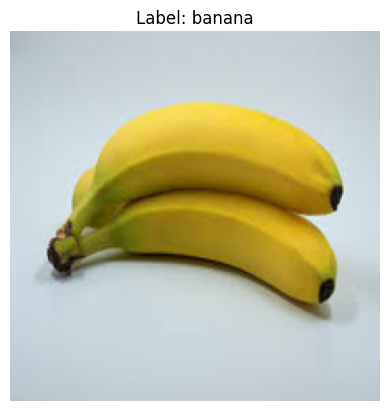

In [33]:
#show thử ảnh
train_features, train_labels = next(iter(train_loader))
print(f'Feature batch shapes: {train_features.size()}')
print(f'Labels batch shapes:{train_labels.size()}')

img = train_features[0].permute(1, 2, 0)
label = train_labels[0].item()
plt.imshow(img)
plt.axis("off")
plt.title(f'Label: {classes[label]}')
plt.show()

# Model

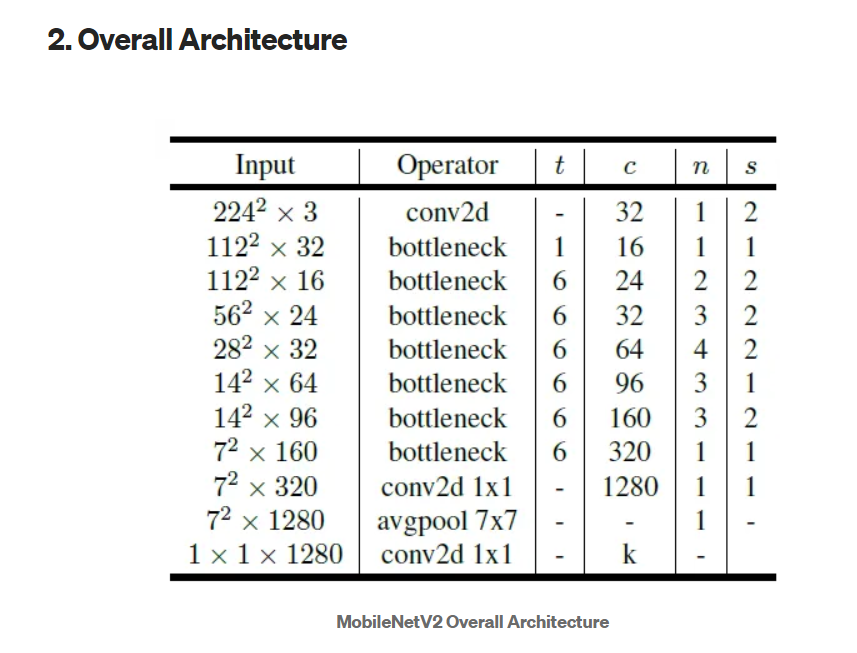

In [34]:
import torch.nn as nn
import math


def _make_divisible(v, divisor, min_value=None):
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    It can be seen here:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    :param v:
    :param divisor:
    :param min_value:
    :return:
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

In [35]:
def conv_3x3_bn(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )


def conv_1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )


class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        assert stride in [1, 2]

        hidden_dim = round(inp * expand_ratio)
        self.identity = stride == 1 and inp == oup

        if expand_ratio == 1:
            self.conv = nn.Sequential(
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )

    def forward(self, x):
        if self.identity:
            return x + self.conv(x)
        else:
            return self.conv(x)

In [36]:
class MobileNetV2(nn.Module):
    def __init__(self, num_classes=10, width_mult=1.):
        super(MobileNetV2, self).__init__()
        # setting of inverted residual blocks
        self.cfgs = [
            # t, c, n, s
            [1,  16, 1, 1],
            [6,  24, 2, 2],
            [6,  32, 3, 2],
            [6,  64, 4, 2],
            [6,  96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]

        # building first layer
        input_channel = _make_divisible(32 * width_mult, 4 if width_mult == 0.1 else 8)
        layers = [conv_3x3_bn(3, input_channel, 2)]
        # building inverted residual blocks
        block = InvertedResidual
        for t, c, n, s in self.cfgs:
            output_channel = _make_divisible(c * width_mult, 4 if width_mult == 0.1 else 8)
            for i in range(n):
                layers.append(block(input_channel, output_channel, s if i == 0 else 1, t))
                input_channel = output_channel
        self.features = nn.Sequential(*layers)
        # building last several layers
        output_channel = _make_divisible(1280 * width_mult, 4 if width_mult == 0.1 else 8) if width_mult > 1.0 else 1280
        self.conv = conv_1x1_bn(input_channel, output_channel)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(output_channel, num_classes)

        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.conv(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()

In [37]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = MobileNetV2(10).to(device)
from torchsummary import summary
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

# Training

In [38]:
def evaluate(model, dataloader, criterion, device):
  model.eval()
  correct = 0
  total = 0
  losses = []
  with torch.no_grad():
    for inputs, labels in dataloader:
      inputs, labels = inputs.to(device), labels.to(device)
      logits = model(inputs)
      loss = criterion(logits, labels)
      losses.append(loss.item())
      correctly_predicted = (logits.argmax(-1) == labels).sum().item()
      correct += correctly_predicted
      total += labels.size(0)

  loss = sum(losses) / len(losses)
  acc = correct / total

  return loss, acc

In [39]:
def fit(model, train_loader, val_loader, criterion, optimizer, device, epochs):
  train_losses = []
  val_losses = []

  for epoch in range(epochs):
    batch_train_losses = []

    model.train()
    for idx, (inputs, labels) in enumerate(train_loader):
      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()
      logits = model(inputs)

      loss = criterion(logits, labels)
      loss.backward()
      optimizer.step()
      batch_train_losses.append(loss.item())

    train_loss = sum(batch_train_losses) / len(batch_train_losses)
    train_losses.append(train_loss)

    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    val_losses.append(val_loss)

    print(f'EPOCH: {epoch + 1}:\tTrain Loss:{train_loss:4f}\tVal Loss:{val_loss:4f}')

  return train_losses, val_losses


In [40]:
lr = 1e-2
epochs = 25

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr
)

In [41]:
train_losses, val_losses = fit(model, train_loader, val_loader, criterion, optimizer, device, epochs)

EPOCH: 1:	Train Loss:2.443792	Val Loss:2.062394
EPOCH: 2:	Train Loss:1.813019	Val Loss:1.816832
EPOCH: 3:	Train Loss:1.752449	Val Loss:2.284245
EPOCH: 4:	Train Loss:1.671822	Val Loss:1.660985
EPOCH: 5:	Train Loss:1.574480	Val Loss:1.659830
EPOCH: 6:	Train Loss:1.529922	Val Loss:1.631782
EPOCH: 7:	Train Loss:1.490665	Val Loss:1.674452
EPOCH: 8:	Train Loss:1.439991	Val Loss:2.663332
EPOCH: 9:	Train Loss:1.392760	Val Loss:2.349974
EPOCH: 10:	Train Loss:1.337724	Val Loss:2.242089
EPOCH: 11:	Train Loss:1.338837	Val Loss:1.348460
EPOCH: 12:	Train Loss:1.249067	Val Loss:1.522738
EPOCH: 13:	Train Loss:1.292722	Val Loss:1.962120
EPOCH: 14:	Train Loss:1.239570	Val Loss:2.707658
EPOCH: 15:	Train Loss:1.262693	Val Loss:1.347817
EPOCH: 16:	Train Loss:1.207363	Val Loss:1.779604
EPOCH: 17:	Train Loss:1.203558	Val Loss:1.407294
EPOCH: 18:	Train Loss:1.122706	Val Loss:1.550805
EPOCH: 19:	Train Loss:1.145464	Val Loss:1.301562
EPOCH: 20:	Train Loss:1.163325	Val Loss:1.327207
EPOCH: 21:	Train Loss:1.08856

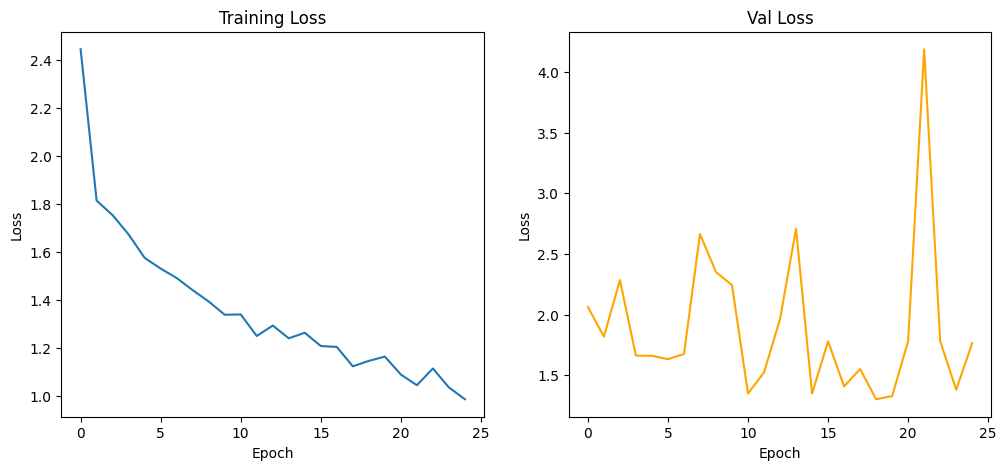

In [42]:
fig, ax = plt.subplots(1,2, figsize=(12, 5))
ax[0].plot(train_losses)
ax[0].set_title("Training Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[1].plot(val_losses, color='orange')
ax[1].set_title("Val Loss")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")
plt.show()

In [44]:
val_loss, val_acc = evaluate(
    model,
    val_loader,
    criterion,
    device
)


print('Evaluation on val/test dataset')
print('Val accuracy: ', val_acc)

Evaluation on val/test dataset
Val accuracy:  0.47024390243902436


# Inference

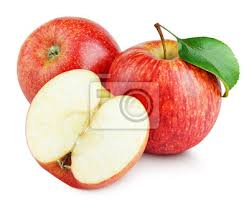

In [59]:
image_path = '/content/MY_data/predict/0.jpeg'
img = Image.open(image_path)
img

In [ ]:
image_path = '/content/MY_data/predict/0.jpeg'
img = Image.open(image_path)
img.show()
norm_img = transform_val_n_test(img).unsqueeze(0).to(device)
model.eval()
with torch.no_grad():
    logits = model(norm_img)

In [56]:
predicted = torch.argmax(logits).item()
print(classes[predicted])

apple


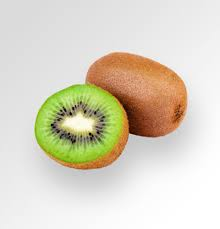

In [60]:
image_path = '/content/MY_data/predict/202.jpeg'
img = Image.open(image_path)
img

In [62]:
image_path = '/content/MY_data/predict/202.jpeg'
img = Image.open(image_path)

norm_img = transform_val_n_test(img).unsqueeze(0).to(device)
model.eval()
with torch.no_grad():
    logits = model(norm_img)

In [63]:
predicted = torch.argmax(logits).item()
print(classes[predicted])

banana


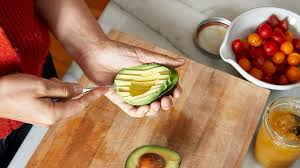

In [66]:
image_path = '/content/MY_data/predict/img_21.jpeg'
img = Image.open(image_path)
img



In [69]:
image_path = '/content/MY_data/predict/img_21.jpeg'
img = Image.open(image_path)

norm_img = transform_val_n_test(img).unsqueeze(0).to(device)
model.eval()
with torch.no_grad():
    logits = model(norm_img)

In [70]:
predicted = torch.argmax(logits).item()
print(classes[predicted])

pinenapple


Load more batchsize, train more epoch

